# SGT ($\beta \neq 0 $) calculation for fluids mixtures with SAFT-$\gamma$-Mie

In this notebook, the SGT ($\beta \neq 0 $) calculations for fluid mixtures with ```saftgammamie``` EoS are illustrated.

When using $\beta \neq 0 $, the cross-influence parameters are computed as $c_{ij} = (1-\beta_{ij})\sqrt{c_{ii}c_{jj}}$.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS and SGT functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sgtpy import component, mixture, saftgammamie

Now, pure components are configured and created with the ```component``` function. To use SGT it is required to set the influence parameter (```cii```) for the pure fluids. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook, the calculations are exemplified for the mixture of ethanol + water and the mixture of hexane + ethanol.

In [2]:
ethanol = component(GC={'CH3':1, 'CH2OH':1}, cii=4.1388468864244875e-20)
water = component(GC={'H2O':1}, cii=1.6033244745871344e-20)

# creating mixture with mixture class function
mix1 = mixture(ethanol, water)
# or creating mixture by adding pure components
mix1 = ethanol + water

mix1.saftgammamie()
eos1 = saftgammamie(mix1)

Now, it is required to compute the phase equilibria (VLE, LLE or VLLE). See Notebooks 5 to 10 for more information about phase equilibria computation.

In this example, the bubble point of the mixture of ethanol and water at $x_1=0.2$ and 298.15K is computed.

In [3]:
from sgtpy.equilibrium import bubblePy

T = 298.15 # K
# liquid composition
x = np.array([0.2, 0.8])
# initial guesses
P0 = 1e4 # Pa
y0 = np.array([0.8, 0.2])
sol = bubblePy(y0, P0, x, T, eos1, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2
rhol = x/vl
rhov = y/vv

In order to set the $\beta$ correction is necessary to create the symmetric matrix of shape (`nc, nc`) and then use it with the  ```eos.beta_sgt``` method from the eos. The $\beta_{ij}$ correction is computed as follows:

$$ \beta_{ij} =  \beta_{ij,0} + \beta_{ij,1} \cdot T +  \beta_{ij,2} \cdot T^2 + \frac{\beta_{ij,3}}{T} $$

Alternatively, you can modify just the pair $ij$ using the `eos.set_betaijsgt` method. In both methods, by default only the $\beta_{ij,0}$ is required. The temperature dependent parameters are optional, if they are not provided they are assumed to be zero.

The function ```sgt_mix_beta0``` is used to study the interfacial behavior with SGT and $\beta=0$. AS shown in Notebook 12, Liang method can compute the density paths correctly.

In [4]:
from sgtpy.sgt import sgt_mix_beta0
bij = 0.0
beta = np.array([[0, bij], [bij, 0]])
eos1.beta_sgt(beta)
# or by setting the beta correction by pair i=0 (hexane), j=1 (ethanol)
eos1.set_betaijsgt(i=0, j=1, beta0=bij)

soll = sgt_mix_beta0(rhov, rhol, T, P, eos1, n=300, method='liang', full_output=True)

When using $\beta \neq 0$ two options are available to solve SGT.

- ```sgt_mix```: solves SGT system as a boundary value problem using orthogonal collocation (increasing interfacial length).
- ```msgt_mix```: solves a stabilized SGT system as a boundary value problem using orthogonal collocation (fixed interfacial length).

In [5]:
from sgtpy.sgt import sgt_mix

bij = 0.2
beta = np.array([[0, bij], [bij, 0]])
eos1.beta_sgt(beta)
# or by setting the beta correction by pair i=0 (ethanol), j=1 (water)
eos1.set_betaijsgt(i=0, j=1, beta0=bij)

solbeta = sgt_mix(rhov, rhol, T, P, eos1, full_output=True)

In [6]:
from sgtpy.sgt import msgt_mix
bij = 0.5
beta = np.array([[0, bij], [bij, 0]])
eos1.beta_sgt(beta)
# or by setting the beta correction by pair i=0 (ethanol), j=1 (water)
eos1.set_betaijsgt(i=0, j=1, beta0=bij)

msolbeta = msgt_mix(rhov, rhol, T, P, eos1, rho0 = solbeta,  full_output=True)

The interfacial tension results are shown below.

In [7]:
print('Liang path Function: ', soll.tension, 'mN/m')
print('SGT BVP: ', solbeta.tension, 'mN/m')
print('Modified SGT BVP: ', msolbeta.tension, 'mN/m')

Liang path Function:  35.70200225956214 mN/m
SGT BVP:  35.50582328558708 mN/m
Modified SGT BVP:  34.35655823070909 mN/m


The density profiles are plotted below. It can be seen that using a $\beta$ correction smooths the density profiles.

Text(0.5, 0, 'path function / 1000')

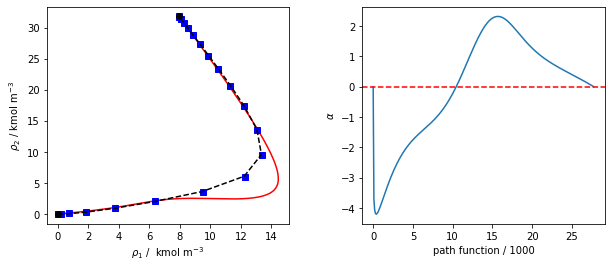

In [8]:
rhobeta = solbeta.rho  / 1000  # kmol/m3
mrhobeta = msolbeta.rho / 1000  # kmol/m3

rholiang =  soll.rho / 1000  # kmol/m3
alphas = soll.alphas
path = soll.path

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhobeta[0], rhobeta[1], 's', color = 'blue')
ax1.plot(mrhobeta[0], mrhobeta[1], '--', color = 'black')
ax1.plot(rhov[0]/1000, rhov[1]/1000, 'o', color = 'k')
ax1.plot(rhol[0]/1000, rhol[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

## Hexane - Ethanol

The interfacial behavior of this mixture is well known to be difficult to study as its displays multiple stationary points in the inhomogeneous zone. 

In [9]:
hexane = component(GC={'CH3':2, 'CH2':4}, cii=3.288396028761707e-19)

mix2 = mixture(hexane, ethanol)
mix2.saftgammamie()
eos2 = saftgammamie(mix2)

In this example, the bubble point of the mixture at $x_1=0.3$ and 298.15K is computed with the ```bubblePy``` function.

In [10]:
T = 298.15 # K
x = np.array([0.3, 0.7])
y0 = 1.*x
P0 = 8000. # Pa
sol = bubblePy(y0, P0, x, T, eos2, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2
rhox = x/vl
rhoy = y/vv
sol

      T: 298.15
      P: 24565.96219155949
  error: 7.055689366097795e-12
   iter: 7
      X: array([0.3, 0.7])
     v1: 7.871213436279095e-05
  Xassl: array([0.07624009, 0.53812004])
 state1: 'Liquid'
      Y: array([0.72958876, 0.27041124])
     v2: 0.0998076488693117
  Xassv: array([0.99406146, 0.99703073])
 state2: 'Vapor'
 method: 'quasi-newton + ASS'

The function ```sgt_mix_beta0``` is used to study the interfacial behavior with SGT and $\beta=0$. AS shown in Notebook 12, Liang method can compute the density paths correctly.

In [11]:
soll2 = sgt_mix_beta0(rhoy, rhox, T, P, eos2, n=300, method='liang', full_output=True)

/Users/gac21/Documents/sgtpy/sgtpy/gammamie_mixtures/ahs_monomer.py:121: RuntimeWarning: invalid value encountered in log
  log3 = np.log(xhi3_1)
/Users/gac21/Documents/sgtpy/sgtpy/gammamie_mixtures/gdHS_chain.py:134: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)
/Users/gac21/Documents/sgtpy/sgtpy/gammamie_mixtures/ares.py:926: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2


SGT is solved with $\beta = 0.2$ and $\beta = 0.5$ using the ```sgt_mix``` and ```msgt_mix``` function.

In [12]:
bij = 0.2
beta = np.array([[0, bij], [bij, 0]])
eos2.beta_sgt(beta)
# or by setting the beta correction by pair i=0 (hexane), j=1 (ethanol)
eos2.set_betaijsgt(i=0, j=1, beta0=bij)

solbeta = sgt_mix(rhoy, rhox, T, P, eos2, full_output=True)

In [13]:
bij = 0.5
beta = np.array([[0, bij], [bij, 0]])
eos2.beta_sgt(beta)
# or by setting the beta correction by pair i=0 (hexane), j=1 (ethanol)
eos2.set_betaijsgt(i=0, j=1, beta0=bij)

msolbeta = msgt_mix(rhoy, rhox, T, P, eos2, rho0=solbeta, full_output=True)

The interfacial tension results are shown below.

In [14]:
print('Liang path Function: ', soll2.tension, 'mN/m')
print('SGT BVP: ', solbeta.tension, 'mN/m')
print('Modified SGT BVP: ', msolbeta.tension, 'mN/m')

Liang path Function:  16.353369316420647 mN/m
SGT BVP:  16.771852772836933 mN/m
Modified SGT BVP:  16.006470310232434 mN/m


The density profiles are plotted below. It can be seen that using a $\beta$ correction smooths the density profiles and reduces the number of stationary points.

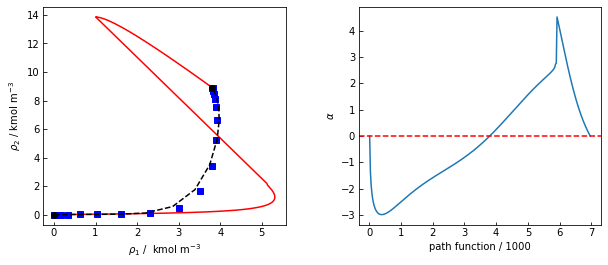

In [15]:
rhobeta = solbeta.rho  / 1000  # kmol/m3
mrhobeta = msolbeta.rho / 1000  # kmol/m3

rholiang =  soll2.rho / 1000 # kmol/m3
alphas = soll2.alphas
path = soll2.path

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhobeta[0], rhobeta[1], 's', color = 'blue')
ax1.plot(mrhobeta[0], mrhobeta[1], '--', color = 'black')

ax1.plot(rhoy[0]/1000, rhoy[1]/1000, 'o', color = 'k')
ax1.plot(rhox[0]/1000, rhox[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
# fig.savefig('sgt_mix.pdf')

For further information of any of these functions just run: ```function?```